<a href="https://colab.research.google.com/github/letun1987/Diploma-project/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_DA_66_%D0%9F%D0%B0%D1%80%D1%81%D0%B8%D0%BD_Habr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дипломный проект на тему "**Анализ рынка вакансий по данным сайта 'Хабр Карьера' (парсинг данных, поиск инсайтов, составление рекомендаций стейкхолдерам)**"


In [ ]:
import pandas as pd
import time
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import tqdm
from google.colab import files
import seaborn as sns

In [ ]:
def all_vacancy(): # Парсер обрабатывает полностью все вакансии

  res = requests.get('https://career.habr.com/vacancies?page=1&type=all')
  res.status_code
  if res.status_code == 200:  #Задаем условие, что если ссылка в порядке отрабатываем алгоритм, иначе выводит ошибку

    global df_all
    df_all = pd.DataFrame() # Создаем датафрейм, в который помещаем спарсенные данные

    for p in tqdm.tqdm(range(1, 155), bar_format="{l_bar}{bar:155}{r_bar}", desc ="Parsing Happiness"): # Задаем цикл для парсинга всех страниц сайта
      url = f"https://career.habr.com/vacancies?page={p}&type=all" #155
      r = requests.get(url)
      time.sleep(1)
      soup = BeautifulSoup(r.text)
      list_of_vacancy = soup.find_all('div', class_='vacancy-card')
      for el in list_of_vacancy:
        title = el.find('a', 'vacancy-card__title-link').text
        company = el.find('a', 'link-comp link-comp--appearance-dark').text
        link ="https://career.habr.com/" + el.find('a', 'vacancy-card__title-link').get('href')
        date = el.find('time', 'basic-date').text
        skills = el.find('div', 'vacancy-card__skills').text.strip().replace('•', ',')
        salary = el.find('div', 'basic-salary').text.strip().replace(' ', '')
        salary = re.findall('\D+|\d+', salary)
        if len(salary)==0: # Если зарплата не указана, заполняем ячейку np.nan
          salary=np.nan
        else:
          salary
        remote = el.find('div', 'vacancy-card__meta').text.strip().replace('•', ',').strip().split(',')
        row = {'vacancy_name': title, 'company': company, 'remote':remote,'link': link, 'date': date, 'skills': skills, 'salary': salary}
        df_all = pd.concat([df_all, pd.DataFrame([row])]).reset_index(drop=True) #создаем датафрейм

    df_all.info()
  else:
    print('Битая ссылка')
all_vacancy()

Parsing Happiness: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154/154 [07:14<00:00,  2.82s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3551 entries, 0 to 3550
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   vacancy_name  3551 non-null   object
 1   company       3551 non-null   object
 2   remote        3551 non-null   object
 3   link          3551 non-null   object
 4   date          3551 non-null   object
 5   skills        3551 non-null   object
 6   salary        639 non-null    object
dtypes: object(7)
memory usage: 194.3+ KB


Описании столбцов таблицы:

1. vacancy_name - название вакансии
2. company - название компании
3. remote - тип занятости/город локации
4. link - ссылка на вакансию
5. date - дата размещения вакансии
6. skills - навыки
7. salary - уровень заработной платы

В таблице 3551 строк.

In [ ]:
df_all.head(5)

,vacancy_name,company,remote,link,date,skills,salary
0,"Руководитель ИТ-проектов (проектный офис, тран...",Hoff Tech,"[Москва , Полный рабочий день]",https://career.habr.com//vacancies/1000124365,13 августа,"Менеджер проекта, Старший (Senior) , Agile , У...",NaN
1,"Разработчик Fullstack (React, Python)",Bell Integrator,"[Москва , Санкт-Петербург , Сочи , Полный р...",https://career.habr.com//vacancies/1000127669,13 августа,"Бэкенд разработчик, Средний (Middle) , Python ...",NaN
2,Тестировщик/QA Инженер,ГК Астра,"[Москва , Полный рабочий день]",https://career.habr.com//vacancies/1000077423,13 августа,"Инженер по ручному тестированию, Средний (Midd...",NaN
3,Технический писатель в команду Salute2B Цифров...,Сбер,"[Москва , Полный рабочий день , Можно удаленно]",https://career.habr.com//vacancies/1000112549,13 августа,"Технический писатель, Средний (Middle) , Техни...",NaN
4,Project Manager в Цифровые поверхности Салют (...,Сбер,"[Москва , Полный рабочий день , Можно удаленно]",https://career.habr.com//vacancies/1000112551,13 августа,"Менеджер проекта, Средний (Middle) , Управлени...",NaN


Посмотрим на пропущенные значения, они имеются только в одном столбце salary, к сожалению, не все работодатели озвучивают в объявления уровень заработной платы, так что зарплата указана только в 18% случаях.

<Axes: >

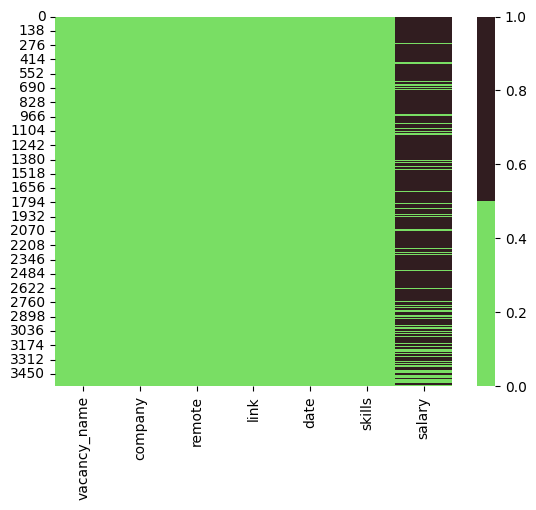

In [ ]:
colours = ['#79de64', '#311d20']
sns.heatmap(df_all.isnull(), cmap=sns.color_palette(colours))

In [ ]:
for col in df_all.columns: # считаем пропуски в каждом столбце
    pct_missing = np.mean(df_all[col].isnull())
    print('{} - {}% пропущенных значений'.format(col, round(pct_missing*100)))

vacancy_name - 0% пропущенных значений
company - 0% пропущенных значений
remote - 0% пропущенных значений
link - 0% пропущенных значений
date - 0% пропущенных значений
skills - 0% пропущенных значений
salary - 82% пропущенных значений


Загрузим спарсенные данные на локальный компьютер в csv формате, установив в качестве разделителя между столбцами знак табуляции.

In [ ]:
df_all.to_csv('parsing.csv', index=False, sep='\t')
files.download('parsing.csv')

Для удобства форматирования и обработки данных создадим копию нашего датафрейма, и далее будем работать с нею

In [ ]:
df_1 = df_all.copy()
df_1.head()

,vacancy_name,company,remote,link,date,skills,salary
0,Инженер технической поддержки (DION),Холдинг Т1,"[Москва , Санкт-Петербург , Полный рабочий д...",https://career.habr.com//vacancies/1000129508,20 августа,"Инженер технической поддержки, Средний (Middle...",NaN
1,Middle DevOps engineer [GR Canal],МТС,"[Москва , Санкт-Петербург , Полный рабочий д...",https://career.habr.com//vacancies/1000127160,13 августа,"DevOps-инженер, Старший (Senior) , Linux , Git...",NaN
2,Ведущий инженер SDS Ceph,Холдинг Т1,"[Москва , Полный рабочий день]",https://career.habr.com//vacancies/1000129506,20 августа,"Системный администратор, Средний (Middle) , Op...",NaN
3,Senior java developer (проект ЦФА),Холдинг Т1,"[Москва , Санкт-Петербург , Екатеринбург , ...",https://career.habr.com//vacancies/1000129507,20 августа,"Бэкенд разработчик, Старший (Senior) , Java , ...",NaN
4,SRE/Системный администратор Linux (Одноклассники),VK,"[Москва , Санкт-Петербург , Полный рабочий д...",https://career.habr.com//vacancies/1000120021,13 августа,"Системный администратор, Старший (Senior) , Li...",NaN


Перейдем к подготовке и обработке данных в столбцах таблицы. Начнем с столбца remote. Как видно из набора значений - данные в каждой строке могут состоять из различных комбинаций названий городов (города) и типа занятости. Типов занятости всего есть 3 вариантов ( Полный рабочий день ,  Можно удаленно, Неполный рабочий день).

In [ ]:
df_1['remote'].value_counts().head(20)

[Полный рабочий день ,  Можно удаленно]                                                    1118
[Москва ,  Полный рабочий день]                                                             606
[Москва ,  Полный рабочий день ,  Можно удаленно]                                           391
[Можно удаленно]                                                                            146
[Санкт-Петербург ,  Полный рабочий день]                                                     81
[Москва ,  Санкт-Петербург ,  Полный рабочий день ,  Можно удаленно]                         76
[Москва]                                                                                     69
[Санкт-Петербург ,  Полный рабочий день ,  Можно удаленно]                                   56
[Москва ,  Санкт-Петербург ,  Полный рабочий день]                                           53
[Неполный рабочий день ,  Можно удаленно]                                                    46
[Москва ,  Санкт-Петербург ,  Нижний Нов

Создадим новый столбец kind_of_work, где будет указан только тип занятости, без названия города.

In [ ]:
def kind_of_work(row):

  list_of_works = []
  for i in row:
    i = i.strip()
    if i == 'Можно удаленно':
      list_of_works.append(i)
    elif i == 'Полный рабочий день':
      list_of_works.append(i)
    elif i == 'Неполный рабочий день':
      list_of_works.append(i)

  return list_of_works

df_1['kind_of_work'] = df_1['remote'].apply(kind_of_work)

Далее перейдем к типу занятости, столбец 'kind_of_work'. Приводим варианты работы к строкову типу и далее заполняем отсуствующие значения "Офис", т.к. не указан удаленный формат работы в параметрах вакансии. Как видно из данных, более 60% вакансий предусматривают удаленный формат работы.

In [ ]:
df_1['kind_of_work'].value_counts()

[Полный рабочий день, Можно удаленно]      2006
[Полный рабочий день]                      1173
[Можно удаленно]                            197
[]                                          100
[Неполный рабочий день, Можно удаленно]      69
[Неполный рабочий день]                      24
Name: kind_of_work, dtype: int64

In [ ]:
df_1['kind_of_work'] = df_1['kind_of_work'].apply(', '.join)
df_1['kind_of_work'] = df_1['kind_of_work'].apply(lambda x: np.nan if len(x)==0 else x)
df_1["kind_of_work"].fillna("Офис", inplace = True)

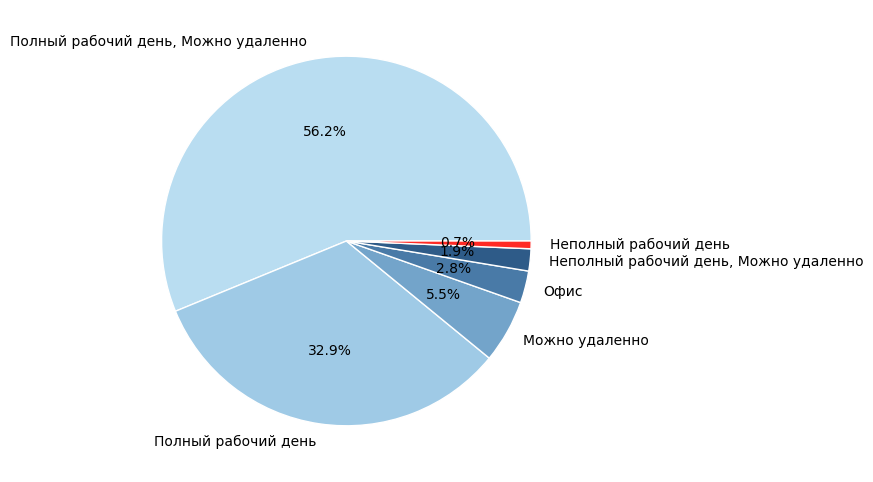

In [ ]:
colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88", "#ff2A25"]
labels = df_1['kind_of_work'].value_counts().index
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
ax.pie(df_1['kind_of_work'].value_counts(),labels=labels, colors = colors, autopct = '%1.1f%%',
      wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.show()

После этого удалим информацию о типе занятости из столбца remote, оставив там только названия городов.

In [ ]:
def del_kind_of_work(row): #удаляем значения 'Можно удаленно', 'Полный рабочий день' из столбца remote
  unwanted_item = {'Можно удаленно', 'Полный рабочий день', 'Неполный рабочий день'}
  list_1 = [ele for ele in row if ele.strip() not in unwanted_item]
  return list_1

df_1['remote'] = df_1['remote'].apply(del_kind_of_work)

Далее столбец date - он имеет формат записи число и месяц и тип данных object. Приобразуем все это в формат datetime день-месяц-год.

In [ ]:
def add_year(row):

  for x,y in ('июля', '07'), ('августа', '08'):
    row = row.replace(x,y)
    year = ' 2023'
    new_row = (row + year).strip()
  new_row = datetime.strptime(new_row, '%d %m %Y')
  return new_row

df_1['date'] = df_1['date'].apply(add_year)

Далее перейдем к столбцу с зарплатами. Мы помним, что тут у нас 82% пропущенных значений и к тому же очень неудобная структура записи информации, а именно могут встречаться варианты " от сумма до сумма", "от сумма", "до сумма", "сумма". Зарплата может исчисляться в рублях, евро, долларах и тенге. Задача по очистке данных сводиться к следующим действиям:

1. Создаем два столбца "salary_from"(зарплата от) и "salary_to"(зарплата до).
2. Удаление символ платежных валют и переводим значения в целочисленный формат.
3. Приведения значений в единую систему исчисления, а именно в рубли. Т.к. проект исследовательский, а текущий уровень инфляции очень большой, плюс большая волатильность на рынке валют, то курс доллара и евро будем считать 1 к 100 рублям, а курс тенге 1 к 4.58.

In [ ]:
def add_3(row): # Создаем столбец с зарплатами от
  if row != 'missing':
    if row[0] == 'от':
      return row[1]+row[-1]
    elif row[0] != 'от' and row[0] != 'до':
      return row[0]+row[-1]

df_1['salary_from'] = df_1['salary'].fillna("missing").apply(add_3) #Зарплата от

In [ ]:
def add_4(row): #Создадем столбец с зарплатами до
  if row != 'missing':
    try:
      if row[0] == 'до':
        return row[1]+row[-1]
      elif row[2] == 'до':
        return row[3]+row[-1]
    except Exception:
      pass

df_1['salary_to'] = df_1['salary'].fillna("missing").apply(add_4)

In [ ]:
df_1.replace(to_replace=[None], value=np.nan, inplace=True) # Заменяем значение None на np.Nan

In [ ]:
def exchange(row): # удаляем знаки валют

  if row is np.nan:
    pass
  elif row[-1]=='$' or row[-1]=='€':
    row = int(row[:-1])*100
    return row
  elif row[-1]=='₸':
    row = round(int(row[:-1])/4.58799)# тенге в рубли
    return row
  else:
    return int(row[:-1])

df_1['salary_from'] = df_1['salary_from'].apply(exchange)
df_1['salary_to'] = df_1['salary_to'].apply(exchange)

Проверяем изменения, все отлично работает!

In [ ]:
df_1.sample(5)

,vacancy_name,company,remote,link,date,skills,salary,kind_of_work,salary_from,salary_to
3457,React Native Developer,Ranepa Tech,[],https://career.habr.com//vacancies/1000127193,2023-07-26,"Разработчик мобильных приложений, Старший (Sen...","[от, 4400, до, 5300, $]","Полный рабочий день, Можно удаленно",440000.0,530000.0
2912,Performance Test Engineer,Arenadata,[],https://career.habr.com//vacancies/1000128963,2023-08-08,"Инженер по производительности, Средний (Middle...",NaN,"Полный рабочий день, Можно удаленно",NaN,NaN
2237,Android разработчик (middle/senior),Hands App,[],https://career.habr.com//vacancies/1000128060,2023-08-14,"Разработчик мобильных приложений, Средний (Mid...","[от, 180000, ₽]","Полный рабочий день, Можно удаленно",180000.0,NaN
3017,Backend developer (Golang),Сима-ленд,[],https://career.habr.com//vacancies/1000088293,2023-08-07,"Бэкенд разработчик, Средний (Middle) , Golang ...","[от, 150000, ₽]","Полный рабочий день, Можно удаленно",150000.0,NaN
2167,Инженер по сопровождению хранилища данных (DWH),МТС,[Москва ],https://career.habr.com//vacancies/1000123940,2023-08-14,"Разработчик баз данных, Средний (Middle) , ETL...",NaN,"Полный рабочий день, Можно удаленно",NaN,NaN


Посмотрим какие города лидируют по количеству вакансий. Здесь конечно все ожидаемо, Москва на первом месте с 1500 предложений, на втором месте Санкт-Петербург, который троекратно уступает Москве с 549 вакансиями, и с третьего по пятое места расположились Нижний Новгород, Екатеринбург и Казань, там предложения в диапазоне от 120-130 предложений.

In [ ]:
df_1['remote'] = df_1['remote'].apply(','.join) #преобразуем список в строку
df_1['remote'] = df_1['remote'].apply(lambda x: np.nan if len(x)==0 else x) # если список был пустой, то вставляем np.nan
df_1["remote"].fillna("Город не указан", inplace = True) # заменяем np.nan на "Город не указан"

In [ ]:
def data_city (city_to_list): # Создаем датафрейм с названиями городов

  city_to_list = df_1['remote'].str.strip().str.split(',')
  dict_of_city = {}
  count = 1
  for i in city_to_list:
    for b in i:
      b = b.strip()
      if b not in dict_of_city.keys():
        dict_of_city[b] = count
      else:
        dict_of_city[b] += 1
  dict_of_city
  sorted_values = sorted(dict_of_city.items(), key=lambda kv: kv[1], reverse=True) #сортируем значения по убыванию
  df_of_city = pd.DataFrame(sorted_values) #создаем датафрей из отсортированных значений
  df_of_city = df_of_city.rename(columns = { 0 :'city', 1 : 'count'})
  return df_of_city
df_of_city = data_city(df_1['remote']) # ОБЪЯВЛЕНИЕ НОВОГО ДАТАФРЕЙМА
df_of_city.head(10)

,city,count
0,Москва,1552
1,Город не указан,1310
2,Санкт-Петербург,548
3,Нижний Новгород,135
4,Екатеринбург,133
5,Казань,120
6,Новосибирск,98
7,Краснодар,61
8,Самара,50
9,Ростов-на-Дону,43


Я из Тольятти у меня есть фантастические шансы найти работу в своем городе, целых аж три вакансии, а это между прочем 0,083% от общего числа!

In [ ]:
df_of_city[df_of_city['city']=='Тольятти']

,city,count
56,Тольятти,3


Все мимо, аналитики в Тольятти не требуются.

In [ ]:
df_1[df_1['remote'].str.contains('Тольятти')]


,vacancy_name,company,remote,link,date,skills,salary,kind_of_work,salary_from,salary_to
1512,Системный администратор Linux,Банк ПСБ,"Самара , Тольятти",https://career.habr.com//vacancies/1000124625,2023-08-16,"Системный администратор, Младший (Junior) , XM...",NaN,Полный рабочий день,NaN,NaN
1554,Инженер по нагрузочному тестированию/Performan...,Банк ПСБ,"Самара , Тольятти",https://career.habr.com//vacancies/1000127207,2023-08-16,"Инженер по производительности, Средний (Middle...",NaN,Полный рабочий день,NaN,NaN
3479,PHP-разработчик в продуктовую компанию,Detkin&Co,Тольятти,https://career.habr.com//vacancies/1000128185,2023-07-25,"Бэкенд разработчик, Средний (Middle) , PHP , О...","[от, 150000, ₽]",Полный рабочий день,150000.0,NaN


Text(0.5, 1.0, 'Топ-10 городов')

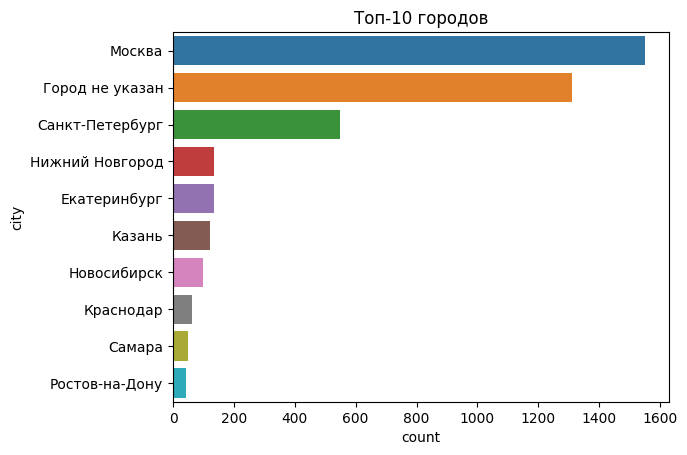

In [ ]:
sns.barplot(data = df_of_city.iloc[0:10], y = 'city', x = 'count').set_title("Топ-10 городов по числу вакансий",
                  fontdict = {'fontsize': 12,
                             'color': 'black'})

Теперь, когда данные готовы, перейдем к описательной статистике. С числовыми переменным у нас всего два столбца salary_from и salary_to:

1. Среднее значения по зарплатам начинаются от 158 000 рублей и верхняя граница 241 000 рублей.
2. Стандартное отклонение 105 000 и 152 000, соответственно - это говорит о том, что значения зарплат очень сильно разбросано вокруг своего среднего значения, как в большую так и меньшую сторону.
3. Минимальная можно получать от 5000 рублей, максимум 1.5 миллиона рублей!
4. 50% всех предложений начинаются для нижней границы от 80 000 и до 200 000, и верхняя граница от 150 000 и до 316 000 рублей.

In [ ]:
round(df_1.describe())

,salary_from,salary_to
count,532.0,404.0
mean,158760.0,241037.0
std,105585.0,152840.0
min,5000.0,10000.0
25%,80000.0,150000.0
50%,150000.0,220000.0
75%,200000.0,316250.0
max,800000.0,1500000.0


Построим гистограммы распределения и график boxplot для визуального просмотра уровня зарплат. Анализируя графики ниже, можно сделать вывод, что "зарплаты от" чаще находятся в диапазоне от 50 000 до 250 000 рублей, самым часто встречающимся предложением является заработная плата в 200 000 рублей.

Text(0.5, 1.0, 'Распределение нижнего порога зарплат')

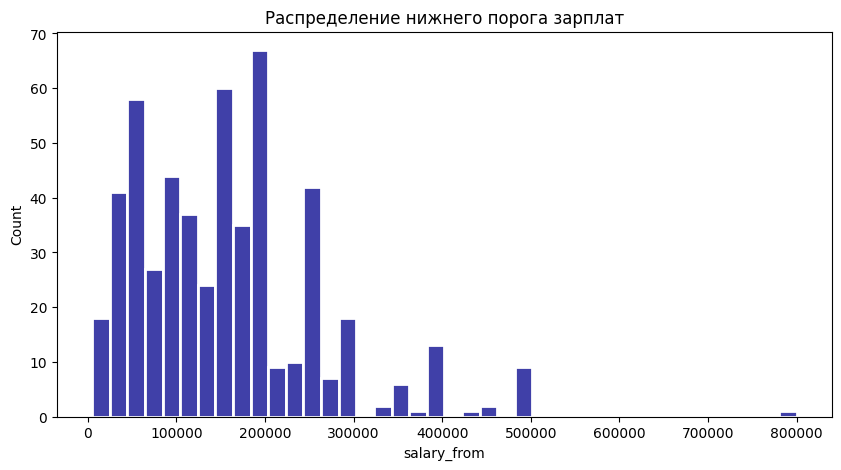

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax=sns.histplot(x = df_1['salary_from'],
             edgecolor = "white",
             linewidth = 2, color='#00008B', bins=40)
ax.set_title("Распределение нижнего порога зарплат")

In [ ]:
df_1['salary_from'].value_counts().head(10)

200000.0    65
150000.0    50
250000.0    39
100000.0    38
120000.0    31
180000.0    23
60000.0     20
80000.0     18
300000.0    18
50000.0     18
Name: salary_from, dtype: int64

Сделаем группировку по компании и посмотрим, кто чаще всего предлагает зарплату от 200 000 рублей. Это Сбер.

Было бы логичным сделать группировку по названию вакансии, но к сожалению названия, пишутся в свободной и хаотичной форме, поэтому четкой логики из такой группировки сделать не получиться.

In [ ]:
df_gr = df_1[df_1['salary_from']==200000].groupby('company', sort=False)['salary_from'].count()
sorted_df = df_gr.sort_values(ascending=False)
sorted_df.head(10)

company
Сбер                      16
МегаФон                    3
Heaad                      2
PROMO IT                   2
Pushflow                   2
Black Shark Recruiting     2
Stivisto Inc.              1
Бристоль                   1
Вебмониторэкс              1
Karma8                     1
Name: salary_from, dtype: int64

Минимальную зарплату на рынке труда в 5000 рублей, предлагает компания Coddy, в 2-х вакансиях из трех ищут стажера. Стажеры нынче не ценятся.

In [ ]:
df_1[df_1['salary_from'] == 5000]

,vacancy_name,company,remote,link,date,skills,salary,kind_of_work,salary_from,salary_to
3116,Стажер в методический отдел школы программиров...,CODDY,Город не указан,https://career.habr.com//vacancies/1000128681,2023-08-03,"Создатель контента, Стажёр (Intern) , Управлен...","[от, 5000, до, 10000, ₽]","Полный рабочий день, Можно удаленно",5000.0,10000.0
3148,Преподаватель Unreal Engine 5,CODDY,"Москва , Санкт-Петербург",https://career.habr.com//vacancies/1000128642,2023-08-02,"Разработчик игр, Стажёр (Intern) , Unreal Engi...","[от, 5000, до, 10000, ₽]","Неполный рабочий день, Можно удаленно",5000.0,10000.0
3215,Стажер в HR отдел,CODDY,Город не указан,https://career.habr.com//vacancies/1000128564,2023-08-01,"Менеджер по персоналу, Стажёр (Intern) , Управ...","[от, 5000, до, 10000, ₽]","Неполный рабочий день, Можно удаленно",5000.0,10000.0


Посмотрим какими навыками надо обладать, чтобы вам платили заработную плату больше 500 000 рублей. Живя в Омске можно спокойно зарабатывать от 800 000 рублей, имея соответствующие навыки и опыт. Отличный уровень дохода для регионов.

In [ ]:
df_top = df_1[df_1['salary_from'] > 500000]
skills_list = []
for i in df_top['skills']:
  i = i.split(',')
  for a in i:
    skills_list.append(a)
print ('\033[1m' + 'Навыки с зарплатой от 600 000 рублей:' + '\033[0m')
print('\n'.join(map(str, skills_list)))
df_top

Навыки с зарплатой от 600 000 рублей:
Технический директор 
 Управление людьми 
 Оптимизация бизнес-процессов 
 Ведение переговоров 
 Управление проектами 
 Построение команды 
 Разработка ТЗ 
 Управление разработкой 
 Автоматизация процессов 
 Информационные технологии 
 Управление IT-услугами


,vacancy_name,company,remote,link,date,skills,salary,kind_of_work,salary_from,salary_to
1080,Технический директор/СТО IT-компании Омский офис,Leantech,Омск,https://career.habr.com//vacancies/1000128567,2023-08-17,"Технический директор , Управление людьми , Опт...","[от, 800000, ₽]",Полный рабочий день,800000.0,NaN


У верхнего потолка зарплат, мы тоже видим распределение вокруг 200 000 рублей на плюс/минус 100 000 рублей, как в верхнюю, так и нижнюю строну.

Text(0.5, 1.0, 'Распределение верхнего порога зарплат')

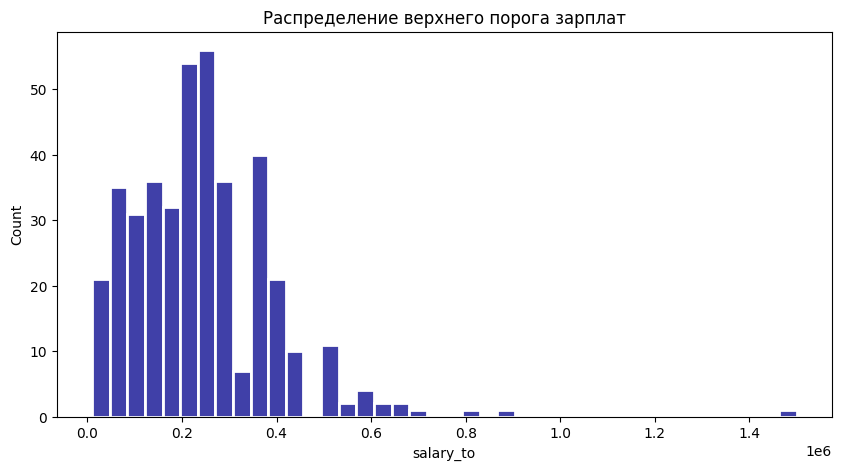

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax = sns.histplot(x = df_1['salary_to'],
             edgecolor = "white",
             linewidth = 2, color='#00008B', bins=40)
ax.set_title("Распределение верхнего порога зарплат")

Самая высокая заработная плата в нашем списке это - "Системный администратор" с верхним потолком оплаты в 1,5 млн. рублей. Вакансия размещена рекрутинговым агентством Recruitment Boutique S.M.Art, специализирующемся на поиске кандидатов для финансового и банковского сектора, указано, что работать необходимо будет в Дубае. Две других вакансии с верхней частью в 800 и 900 тыс. рублей - это backend-разработчики.

In [ ]:
df_top = df_1[df_1['salary_to'] >= 800000]
skills_list = []
for i in df_top['skills']:
  i = i.split(',')
  for a in i:
    skills_list.append(a)
print ('\033[1m' + 'Навыки с зарплатой от 800 000 рублей:' + '\033[0m')
print('\n'.join(map(str, skills_list)))
df_top

Навыки с зарплатой от 800 000 рублей:
Бэкенд разработчик
 Старший (Senior) 
 Разработка программного обеспечения 
 Английский язык 
 Базы данных 
 REST
Системный администратор
 Старший (Senior) 
 Linux 
 VMware 
 Администрирование Windows 
 SQL 
 Active directory 
 Cisco CCNP 
 Администрирование оборудования Cisco 
 Cisco CCNA 
 Администрирование сетей 
 Администрирование Linux
Бэкенд разработчик
 Старший (Senior) 
 MySQL 
 Symfony 
 Redis 
 PHP 
 Высоконагруженные системы 
 Проектирование архитектуры приложений


,vacancy_name,company,remote,link,date,skills,salary,kind_of_work,salary_from,salary_to
824,Lead/Senior Backend Software Engineer,Bitorix,Город не указан,https://career.habr.com//vacancies/1000129066,2023-08-17,"Бэкенд разработчик, Старший (Senior) , Разрабо...","[от, 5000, до, 9000, $]","Полный рабочий день, Можно удаленно",500000.0,900000.0
1488,Senior System Administrator (relocation to Dubai),Recruitment Boutique S.M.Art,"Москва , Санкт-Петербург , Новосибирск",https://career.habr.com//vacancies/1000128460,2023-08-16,"Системный администратор, Старший (Senior) , Li...","[от, 4000, до, 15000, $]",Полный рабочий день,400000.0,1500000.0
3159,Software Architect PHP,Karma8,Город не указан,https://career.habr.com//vacancies/1000126483,2023-08-02,"Бэкенд разработчик, Старший (Senior) , MySQL ,...","[от, 4000, до, 8000, $]","Полный рабочий день, Можно удаленно",400000.0,800000.0


На графике boxplot удобно визуально представить распределение уровня заработный платы по группам, плюс можно выделить значения, которые сильно отличаются от средней заработной платы.

- красные кружочки - значения сильно выше средней зарплаты по группам, так называемые выбросы.
- оранжевая линия - медианное значение зарплаты.
-зеленый пунктир - среднее значение зарплаты.
- голубой прямоугольник - в этом диапазоне находятся 50% все значений зарплат.


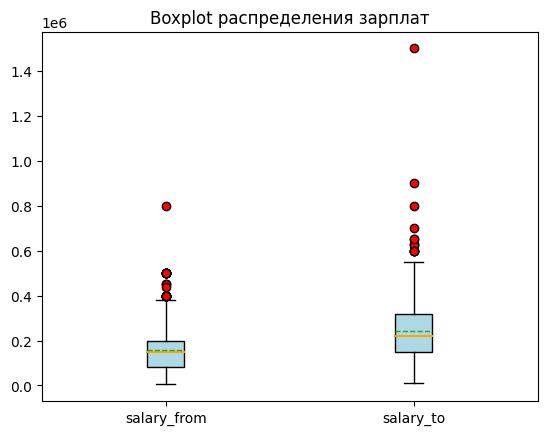

In [ ]:
df_1.boxplot(column=['salary_from', 'salary_to'], grid= False , color='black',
                      flierprops = dict(marker = "o", markerfacecolor = "red"),
                      patch_artist = True, boxprops = dict(facecolor = "lightblue"),
                      medianprops = dict(color = "orange", linewidth = 1.5),
                      showmeans = True, meanline = True)
plt.title('Boxplot распределения зарплат')
plt.show()

Ниже взглянем, а какие навыки (hard skills) в настоящий момент наиболее востребованы на рынке труда.

In [ ]:
def data_skills(skills_to_list): # Создаем датафрейм с навыками

  skills_to_list = df_1['skills'].str.strip().str.split(',')
  dict_of_skills = {}
  count = 1
  for i in skills_to_list:
    for b in i:
      b = b.strip()
      if b not in dict_of_skills.keys():
        dict_of_skills[b] = count
      else:
        dict_of_skills[b] += 1
  dict_of_skills
  sorted_values = sorted(dict_of_skills.items(), key=lambda kv: kv[1], reverse=True) #сортируем значения по убыванию
  df_of_skill = pd.DataFrame(sorted_values) #создаем датафрей из отсортированных значений
  df_of_skill = df_of_skill.rename(columns = { 0 :'skills', 1 : 'count'})
  return df_of_skill
df_of_skill = data_skills(df_all['skills']) # ОБЪЯВЛЕНИЕ НОВОГО ДАТАФРЕЙМА
df_of_skill.head(20)

,skills,count
0,Средний (Middle),1568
1,Старший (Senior),1017
2,Бэкенд разработчик,841
3,SQL,764
4,Python,540
5,Linux,534
6,PostgreSQL,506
7,Java,465
8,Git,405
9,Docker,398


Как видно из визуализации, в настоящий момент, на рынке наиболее востребованы специалисты уровня middle и senior. Если у нас всего примерно 3500 вакансий, то в 74% из них ищут специалистов с хорошим опытом.

Что касается специализации, то безоговорочным лидером является backend-разработчик, более 800 вакансий.

Из языков программирования и различных программ, то первое место уверенно занимает SQL+PostgreSQL, в сумме более 1200 упоминаний, на втором месте Python c 541 вакансией и тройку лидеров замыкает Linux 539.

Text(0.5, 1.0, 'Топ-20 навыков')

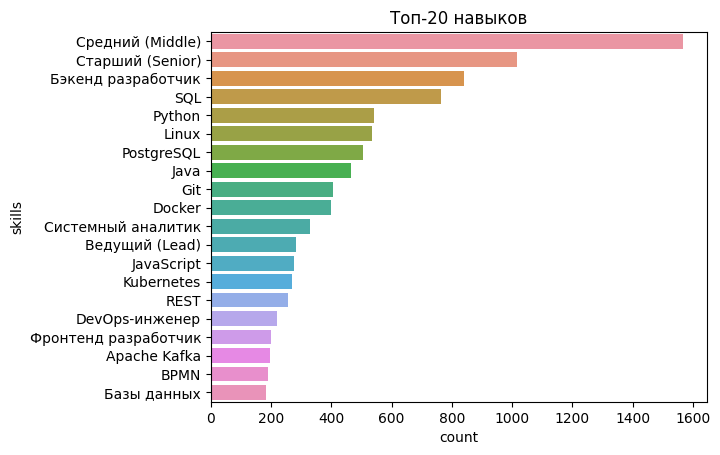

In [ ]:
sns.barplot(data = df_of_skill.iloc[0:20], y = 'skills', x = 'count').set_title("Топ-20 навыков",
                  fontdict = {'fontsize': 12,
                             'color': 'black'})

Интересно также посмотреть чуть глубже, какие навыки есть в середине таблицы, с 20-го по 40-ое место, в среднем эти навыки встречаются в упониманиях от 100 и до 200-та раз. Здесь можно увидеть и стажерские вакансии, примерно 170 упоминаний, т.е. примерно 5% от общега числа вакансий.

Из языков программирования выделим React (JavaScript-библиотека для создания пользовательских интерфейсов), UML(унифицированный язык моделирования), PHP, C++, Golang и др.



Text(0.5, 1.0, 'Навыки с 20-го по 40-ое место')

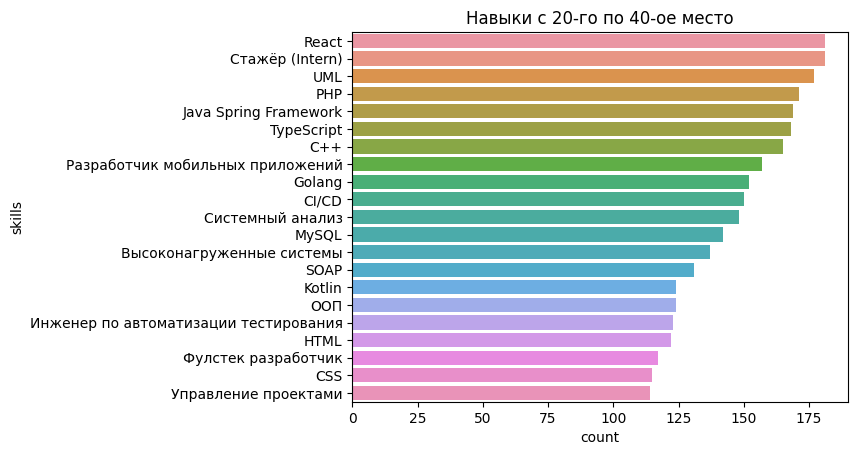

In [ ]:
sns.barplot(data = df_of_skill.iloc[20:41], y = 'skills', x = 'count').set_title("Навыки с 20-го по 40-ое место",
                  fontdict = {'fontsize': 12,
                             'color': 'black'})

Посмотрим на топ-20 компаний по размещенным вакансиям. На первом месте уверенно лидирует компания Bell Integrator, и далее держат позиции финтех компании МТС, СБЕР, Тинькофф, Банк ПСБ, Яндекс, VK.

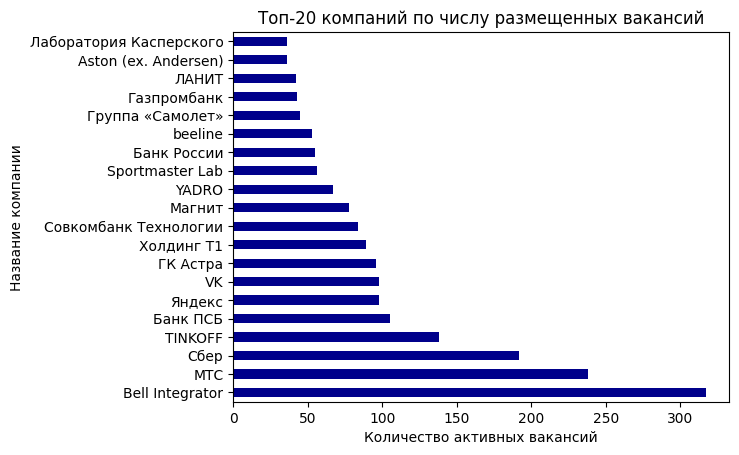

In [ ]:
top_20_company = df_1['company'].value_counts().head(20)# Топ-20 компаний по количеству вакансий
top_20_company.plot(kind = 'barh', color='#00008B', title = 'Топ-20 компаний по числу размещенных вакансий') #Топ-20 компаний по числу ваканси
plt.ylabel('Название компании')
plt.xlabel('Количество активных вакансий')
plt.show()

Ниже создадим отдельный фрейм данных, в который войдут наши компании из топ-20 списка по числу вакансий.

In [ ]:
new_list = [] # создаем список из названия компаний, которые вошли в топ-20
for v in top_20_company.index:
  new_list.append(v)

# создаем отдельный датафрейм, к компаниями из спика new_list
df_top_20 = df_1[df_1['company'].apply(lambda x:x in new_list)]
df_top_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 1 to 2847
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   vacancy_name  1966 non-null   object        
 1   company       1966 non-null   object        
 2   remote        1966 non-null   object        
 3   link          1966 non-null   object        
 4   date          1966 non-null   datetime64[ns]
 5   skills        1966 non-null   object        
 6   salary        77 non-null     object        
 7   kind_of_work  1966 non-null   object        
 8   salary_from   71 non-null     float64       
 9   salary_to     57 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 169.0+ KB


Наиболее востребованной вакансией является "Системный аналитик", более 35 предложений, на втором месте Java-раработчик 33 раза, замыкает тройку DevOps инженер.

In [ ]:
df_top_20['vacancy_name'].value_counts()

Системный аналитик                          35
Разработчик Java                            17
Java разработчик                            16
DevOps инженер                              13
Data engineer                               12
                                            ..
Android developer (МТС еСпортс)              1
Специалист технической поддержки             1
Team Lead / Senior PHP разработчик           1
Системный аналитик (Серверная Астра)         1
Инженер эксплуатации средств защиты сети     1
Name: vacancy_name, Length: 1539, dtype: int64

Сделаем группировку по компаниям, чтобы посмотреть распределение по зарплатам. К сожалению, из 20 компаний, только у 7 есть данные по зарплате, остальные компании не указывают цифры в объявлении.

- синий столбец - это минимальная начальная заработная плата.
- оранжевый столбец - это максимум верхней границы.

Например, можно увидеть, что компания VK предлагает самую высокую начальную зарплату (salary_from) 200 000 рублей, а у Яндекса самая высокая верхняя граница более 600 000 рублей.

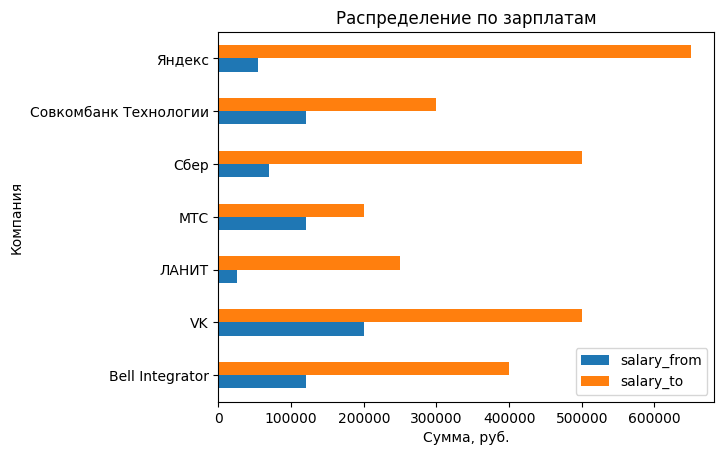

In [ ]:
df_group = df_top_20.groupby('company').agg({'salary_from':'min', 'salary_to':'max'}).reset_index()
df_group.dropna(subset=['salary_from', 'salary_to'],how='all', inplace=True)
df_group.reset_index().plot(
    x="company", y=["salary_from", "salary_to"], kind="barh")
plt.title("Распределение по зарплатам")
plt.ylabel("Компания")
plt.xlabel("Сумма, руб.")
ax.grid(axis = "x")
plt.show()

In [ ]:
df_junior = df_1[df_1['skills'].str.contains('Junior')]
df_junior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 47 to 3515
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   vacancy_name  73 non-null     object
 1   company       73 non-null     object
 2   remote        73 non-null     object
 3   link          73 non-null     object
 4   date          73 non-null     object
 5   skills        73 non-null     object
 6   salary        23 non-null     object
dtypes: object(7)
memory usage: 4.6+ KB


In [ ]:
def junior_skills(skills_to_list): # Создаем датафрейм с навыками джунов

  skills_to_list = df_junior['skills'].str.strip().str.split(',')
  dict_of_skills = {}
  count = 1
  for i in skills_to_list:
    for b in i:
      b = b.strip()
      if b not in dict_of_skills.keys():
        dict_of_skills[b] = count
      else:
        dict_of_skills[b] += 1
  dict_of_skills
  sorted_values = sorted(dict_of_skills.items(), key=lambda kv: kv[1], reverse=True) #сортируем значения по убыванию
  df_of_skill = pd.DataFrame(sorted_values) #создаем датафрей из отсортированных значений
  df_of_skill = df_of_skill.rename(columns = { 0 :'skills', 1 : 'count'})
  return df_of_skill
df_junior_skill = junior_skills(df_junior['skills']) # ОБЪЯВЛЕНИЕ НОВОГО ДАТАФРЕЙМА
df_junior_skill = df_junior_skill.iloc[1:].reset_index(drop=True) # удаляем данную строку, т.к.
# там указан сам навык junior и не отражает важную информацию.
df_junior_skill.head(20)

,skills,count
0,SQL,12
1,Python,9
2,Linux,9
3,JavaScript,9
4,Системный администратор,7
5,Bash,6
6,Инженер технической поддержки,6
7,MySQL,6
8,DevOps-инженер,5
9,Docker,5


Самым востребованным навыком для junior-специалиста является SQL, а вот на втором месте идет Linux (администрирование Linux, Bash), замыкают тройку лидеров Python и JavaScript.

Text(0.5, 1.0, 'Топ-15 навыков Junior-специалиста')

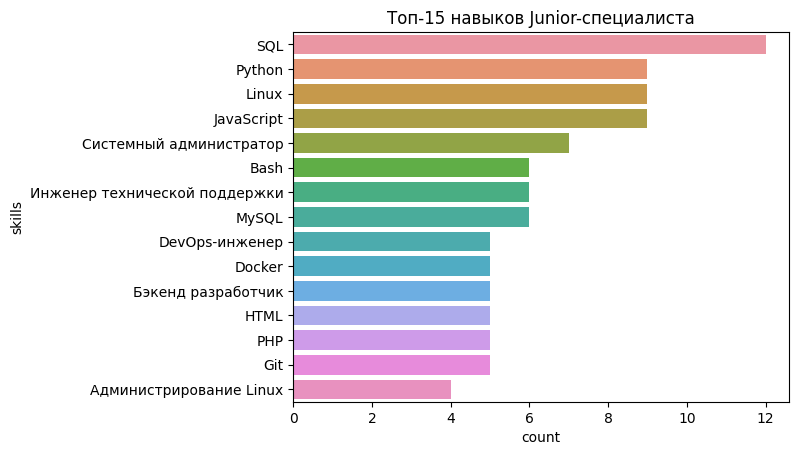

In [ ]:
sns.barplot(data = df_junior_skill.head(15), y = 'skills', x = 'count').set_title("Топ-15 навыков Junior-специалиста",
                  fontdict = {'fontsize': 12,
                             'color': 'black'})

# Итоги проекта и заключение

* В ходе исследования было выявлено, что в настоящий момент рынок в первую очередь нуждается в специалистах уровня middle и senior. Более чем в 60% случаев работодатель готов предложить сотруднику удаленный формат работы.
* Наиболее востребованной профессией на рынке является backend-разработчик.
* Работодатели в первую очередь хотят, чтобы сотрудники владели следующими навыками: SQL, Python, Linux, Java.
* Самой востребованный профессией является «Системный аналитик».
* В среднем работодатели готовы платить сотруднику от 80 000 до 316 000 рублей, все конечно сильно зависит от опыта и навыков.
* Самым привлекательным городом для поиска работы является город Москва.


# Рекомендации стейкхолдерам

**Для образовательных порталов (IT-курсы, школы, университеты)** – подбирать и корректировать учебные программы исходя востребованности на рынке специалистов и специальностей. При проведении маркетинговых компаний использовать актуальные и достоверные данные, отражающие текущую ситуацию. Определять компании, которые наиболее остро нуждаются в сотрудниках для проведения с ними партнерских программ, и подготовки необходимых специалистов.


**Для работодателей (IT-компании)** – оценивать ситуацию на рынке труда, по уровню заработной платы, своевременно индексировать и корректировать, чтобы постоянно находиться в рынке и избегать оттока сотрудников к конкурентам, если причина только в финансовой части. Информация о городах, так же позволяет находить свободные позиции для открытия филиалов и оценки действий конкурентов.
Т.к. более 60 процентов вакансий предусматривают удаленный формат работы – это дает отличную возможность развивать свою деятельность в регионах, позволяя тем самым существенно снижать издержки на аренду офисов и помещений.


